# 0 Imports

In [1]:
import os, warnings
import shutil
from collections import namedtuple
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import json
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner as kt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scripts import read_saves, write_saves, record_saves

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

print("-----------------------------------------")
if tf.test.gpu_device_name():
    print(f"GPU used: {tf.test.gpu_device_name()}")
else:
    print(f"GPU not used")
print("-----------------------------------------")

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

-----------------------------------------
GPU used: /device:GPU:0
-----------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5084991079782961821
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3369533440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3651739767134637225
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-02-03 14:55:14.354812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 14:55:14.368302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:14.395804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:14.396010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

***
# 1 Config

In [60]:
config = {
    "exploration": False,
    "data_augmentation": False,
    "custom": {
        "tune": False,
        "saved": True,
    },
    "transfer": {
        "vgg16": False,
        "xception": False
    }
}

In [3]:
annotations_dir = "data/Annotations"
images_dir = "data/Images"
target_dir = "data/Targets"
batch_size = 16

SAVE_PATH = "data/saves.pkl"
SAVE_NB = 5

***
# 2 Dataset exploration

## 2.0 Utils

In [4]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [5]:
def breeds_distribution(dataset, figsize=(25, 5), display_mean=True):
    plt.figure(figsize=figsize)

    sns.barplot(x=fre_df["Breed"], y=fre_df["Population"])

    if display_mean:
        mean = fre_df.mean(axis=0)[0]
        plt.axhline(mean, linestyle="--", linewidth=1, color="r")

    plt.title("Breeds distribution", size=20)
    plt.xticks(size=10, rotation=45, ha="right")
    plt.yticks(size=10)
    plt.ylabel("Count", size=16)

    if display_mean:
        return mean

***
## 2.1 Breeds distribution

How many breeds are present in the dataset ?

In [6]:
breed_subdir = os.listdir(images_dir)
print(f"There is {len(breed_subdir)} different dog breeds")

There is 120 different dog breeds


Construct a pandas dataset with all breeds and each of their respective population

In [7]:
breed_full: list = []
breed: list = []
population: list = []

for sub_d in breed_subdir:
    breed_full.append(sub_d)
    breed.append(sub_d.split("-")[1])
    population.append(len([obs for obs in os.listdir(images_dir + "/" + sub_d)]))

fre_df = pd.DataFrame(data={"Breed_full": breed_full, "Breed": breed, "Population": population})
fre_df.head()

,Breed_full,Breed,Population
0,n02111889-Samoyed,Samoyed,218
1,n02105641-Old_English_sheepdog,Old_English_sheepdog,169
2,n02107908-Appenzeller,Appenzeller,151
3,n02100583-vizsla,vizsla,154
4,n02097298-Scotch_terrier,Scotch_terrier,158


Plot the breeds populations and the mean

In [8]:
if config["exploration"]:
    mean = breeds_distribution(fre_df)

Let's plot again bu after a sort on Population field

In [9]:
if config["exploration"]:
    fre_df.sort_values(by="Population", inplace=True, ascending=False, axis=0)
    mean = breeds_distribution(fre_df)

Let's take a look at the top three breeds, see if they are sufficiently differents.

In [10]:
if config["exploration"]:

    fix, axs = plt.subplots(3, 3, figsize=(20, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Malteses
    plt.subplot(3, 3, 1)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_37.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 2)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_66.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 3)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_233.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    # Afghan
    plt.subplot(3, 3, 4)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_231.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 5)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_251.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 6)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_272.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    # Scottish deerhound
    plt.subplot(3, 3, 7)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_3.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 8)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_198.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 9)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_86.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

We can see that the images don't have the same size

In [11]:
fre_df = fre_df.iloc[:10,:]
fre_df

,Breed_full,Breed,Population
0,n02111889-Samoyed,Samoyed,218
1,n02105641-Old_English_sheepdog,Old_English_sheepdog,169
2,n02107908-Appenzeller,Appenzeller,151
3,n02100583-vizsla,vizsla,154
4,n02097298-Scotch_terrier,Scotch_terrier,158
5,n02109525-Saint_Bernard,Saint_Bernard,170
6,n02088466-bloodhound,bloodhound,187
7,n02094433-Yorkshire_terrier,Yorkshire_terrier,164
8,n02086079-Pekinese,Pekinese,149
9,n02097130-giant_schnauzer,giant_schnauzer,157


In [12]:
fre_df["Breed"].values.tolist()

['Samoyed',
 'Old_English_sheepdog',
 'Appenzeller',
 'vizsla',
 'Scotch_terrier',
 'Saint_Bernard',
 'bloodhound',
 'Yorkshire_terrier',
 'Pekinese',
 'giant_schnauzer']

In [13]:
# with open("data/brees.list", "wb") as stream:
#     breed_list = fre_df["Breed"].values.tolist()
#     pickle.dump(breed_list, stream)

***
# 3 Dataset preparation

## 3.0 Utils

In [14]:
def sync_dataset_directory(breeds: list, source_dir: str = "data/Images", target_dir: str = "data/Targets"):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.mkdir(target_dir)
    for breed in breeds:
        source = source_dir + "/" + breed
        target = target_dir + "/" + breed
        shutil.copytree(source, target)

***
## 3.1 Without augmentation

In [15]:
if not config["data_augmentation"]:

    sync_dataset_directory(fre_df["Breed_full"])

    ds_train_ = image_dataset_from_directory(
        target_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=[224, 224],
        interpolation="nearest",
        batch_size=16,
        seed=0,
        shuffle=True,
        validation_split=0.8,
        subset="training"
    )

    ds_valid_ = image_dataset_from_directory(
        target_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=[224, 224],
        interpolation="nearest",
        batch_size=4,
        seed=0,
        shuffle=True,
        validation_split=0.2,
        subset="validation"
    )

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

    labels = []
    for label in ds_train_.class_names:
        labels.append(label.split("-")[1])
    
    with open("data/labels.list", "wb") as stream:
        pickle.dump(labels, stream)

Found 1677 files belonging to 10 classes.
Using 336 files for training.
Found 1677 files belonging to 10 classes.
Using 335 files for validation.


2022-02-03 14:55:15.296464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:15.296648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:15.296759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:15.297032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 14:55:15.297152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

***
## 3.2 With augmentation

In [16]:
if config["data_augmentation"]:

    sync_dataset_directory(fre_df["Breed_full"])

    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        zca_whitening=True,
        brightness_range=(0.3, 0.7),
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.5,
        rescale=1./224,
        validation_split=0.2,
        )

    valid_datagen = ImageDataGenerator(
        rescale=1./224,
        validation_split=0.2,
        )

    train_aug = train_datagen.flow_from_directory(
        target_dir,
        target_size=(224, 224),
        subset="training",
        batch_size=16,
        shuffle=True,
        # save_to_dir="data/Augs",
        )

    val_aug = valid_datagen.flow_from_directory(
        target_dir,
        target_size=(224, 224),
        subset="validation",
        batch_size=4,
        shuffle=True
        )

***
# 4 Custom CNN

## 4.0 Utils

In [17]:
def visualize_history(history, figsize=(20, 10), metrics: str = "categorical_accuracy"):
    fix, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    sns.lineplot(data=history, x=history.index, y="loss", label="loss")
    sns.lineplot(data=history, x=history.index, y="val_loss", label="val_loss")
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    sns.lineplot(data=history, x=history.index, y=metrics, label=metrics)
    sns.lineplot(data=history, x=history.index, y="val_" + metrics, label="val_" + metrics)
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

***
## 4.1 Neural Network

### 4.1.1 Model tuning

In [18]:
if config["custom"]["tune"]:

    def build_model(hp):
        kernel_size = hp.Choice("kernel_size", [2, 3])
        pool_size = hp.Choice("pool_size", [2, 3, 4])

        model = keras.Sequential()
        model.add(
            layers.InputLayer(
                input_shape=[224, 224, 3]
            )
        )

        # >>> base <<<
        # > block 1 <
        model.add(
            layers.Conv2D(
                filters=hp.Choice("block_1_conv_1___filters", [16, 32, 64]),
                kernel_size=kernel_size,
                padding="same",
            )
        )
        model.add(
            layers.BatchNormalization()
        )
        model.add(
            layers.Dropout(rate=hp.Float("block_1_dropout_1", min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            layers.Activation(
                activation="relu"
                )
        )
        model.add(
            layers.MaxPool2D(
                pool_size=pool_size,
                padding="same"
            )
        )
        # > block 1: end <

        # > block 2 <
        model.add(
            layers.Conv2D(
                filters=hp.Choice("block_2_conv_1___filters", [16, 32, 64]),
                kernel_size=kernel_size,
                padding="same",
            )
        )
        model.add(
            layers.BatchNormalization()
        )
        model.add(
            layers.Dropout(rate=hp.Float("block_2_dropout_1", min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            layers.Activation(
                activation="relu"
                )
        )
        model.add(
            layers.MaxPool2D(
                pool_size=pool_size,
                padding="same"
            )
        )
        # > block 2: end <

        # > block 3 <
        model.add(
            layers.Conv2D(
                filters=hp.Choice("block_3_conv_1___filters", [16, 32, 64]),
                kernel_size=kernel_size,
                padding="same",
            )
        )
        model.add(
            layers.BatchNormalization()
        )
        model.add(
            layers.Dropout(rate=hp.Float("block_3_dropout_1", min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            layers.Activation(
                activation="relu"
                )
        )
        model.add(
            layers.MaxPool2D(
                pool_size=pool_size,
                padding="same"
            )
        )
        # > block 3: end <
        # >>> base: end <<<

        # >>> head <<<
        model.add(
            layers.Flatten()
        )
        model.add(
            layers.Dense(
                units=hp.Choice("head_dense_2__units", [16, 32, 64, 128, 256]),
                activation="relu"
            )
        )
        model.add(
            layers.Dropout(
                rate=hp.Float("head_dropout_2__rate", min_value=0, max_value=0.5, step=0.1),
            )
        )
        model.add(
            layers.Dense(
                units=fre_df.shape[0],
                activation="softmax"
            )
        )
        # >>> head: end <<<

        # model.summary()

        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"]
        )

        return model

In [19]:
if config["custom"]["tune"]:

    tuner = kt.RandomSearch(
        build_model,
        objective="val_loss",
        max_trials=20,
        executions_per_trial=3,
        overwrite=True,
        directory="keras-tuner",
        project_name="custom-cnn"
    )

    tuner.search(
        ds_train,
        validation_data=ds_valid,
        epochs=20,
        workers=8,
    )

    tuner.search_space_summary()

Trial 20 Complete [00h 01m 29s]
val_loss: 2.2473483085632324

Best val_loss So Far: 2.2473483085632324
Total elapsed time: 00h 45m 35s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 10
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
block_1_conv_1___filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
block_1_dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
block_2_conv_1___filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
block_2_dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
block_3_conv_1___filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
block_3_dropou

In [20]:
if config["custom"]["tune"]:

    tuner.results_summary()

Results summary
Results in keras-tuner/custom-cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
kernel_size: 3
pool_size: 3
block_1_conv_1___filters: 16
block_1_dropout_1: 0.1
block_2_conv_1___filters: 32
block_2_dropout_1: 0.30000000000000004
block_3_conv_1___filters: 64
block_3_dropout_1: 0.1
head_dense_2__units: 128
head_dropout_2__rate: 0.30000000000000004
Score: 2.2473483085632324
Trial summary
Hyperparameters:
kernel_size: 3
pool_size: 3
block_1_conv_1___filters: 16
block_1_dropout_1: 0.0
block_2_conv_1___filters: 64
block_2_dropout_1: 0.1
block_3_conv_1___filters: 64
block_3_dropout_1: 0.30000000000000004
head_dense_2__units: 128
head_dropout_2__rate: 0.30000000000000004
Score: 2.285663684209188
Trial summary
Hyperparameters:
kernel_size: 3
pool_size: 3
block_1_conv_1___filters: 16
block_1_dropout_1: 0.2
block_2_conv_1___filters: 32
block_2_dropout_1: 0.0
block_3_conv_1___filters: 32
block_3_dropout_1: 0.2
head_dense_2__units: 

In [46]:
if config["custom"]["tune"]:

    best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4

In [45]:
if config["custom"]["tune"]:

    best_model = tuner.get_best_models()[0]
    with open("data/custom_save.pkl", "wb") as stream:
        pickle.dump(best_model, stream)

2022-02-03 16:02:19.936908: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://37707bbc-712f-4f4c-8b7a-c401230f1f3b/assets


INFO:tensorflow:Assets written to: ram://37707bbc-712f-4f4c-8b7a-c401230f1f3b/assets


***
### 4.1.2 Saved tuned model

In [61]:
if config["custom"]["saved"]:

    with open("data/custom_save.pkl", "rb") as stream:
        model = pickle.load(stream)

    model.build(input_shape=(224, 224, 3))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4

In [62]:
if config["custom"]["saved"]:

    checkpoint = ModelCheckpoint(
        './base.model',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        period=1
    )

    early_stopping = EarlyStopping(
        min_delta=0.001,
        patience=5,
        restore_best_weights=True
    )

    tensorboard = TensorBoard(
        log_dir="./logs",
        histogram_freq=0,
        write_graph=True,
        write_images=False
    )

    csv_logger = CSVLogger(
        filename="training_csv.log",
        separator=",",
        append=False
    )

    reduce = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1, 
        mode='auto'
    )

    if not config["data_augmentation"]:
        print("Fit without aug")
        history = model.fit(
            ds_train,
            validation_data=ds_valid,
            epochs=50,
            workers=8,
            # callbacks=[early_stopping],
            # verbose=0
        )
    else:
        print("Fit with aug")
        history = model.fit_generator(
            train_aug,
            validation_data=val_aug,
            epochs=1,
            steps_per_epoch=100,
            workers=8
            # callbacks=[early_stopping]
            # verbose=0
        )

Fit without aug
Epoch 1/50
21/21 [==============================] - 2s 73ms/step - loss: 1.2778 - categorical_accuracy: 0.5268 - val_loss: 2.0955 - val_categorical_accuracy: 0.2299
Epoch 2/50
21/21 [==============================] - 1s 68ms/step - loss: 1.2960 - categorical_accuracy: 0.4970 - val_loss: 2.2161 - val_categorical_accuracy: 0.1910
Epoch 3/50
21/21 [==============================] - 1s 65ms/step - loss: 1.1801 - categorical_accuracy: 0.5238 - val_loss: 2.0177 - val_categorical_accuracy: 0.2478
Epoch 4/50
21/21 [==============================] - 1s 71ms/step - loss: 1.1828 - categorical_accuracy: 0.5446 - val_loss: 2.0720 - val_categorical_accuracy: 0.2418
Epoch 5/50
21/21 [==============================] - 1s 64ms/step - loss: 1.1710 - categorical_accuracy: 0.5089 - val_loss: 2.3129 - val_categorical_accuracy: 0.2448
Epoch 6/50
21/21 [==============================] - 1s 65ms/step - loss: 1.1684 - categorical_accuracy: 0.5655 - val_loss: 2.3504 - val_categorical_accuracy: 0

***
## 3.3 Results

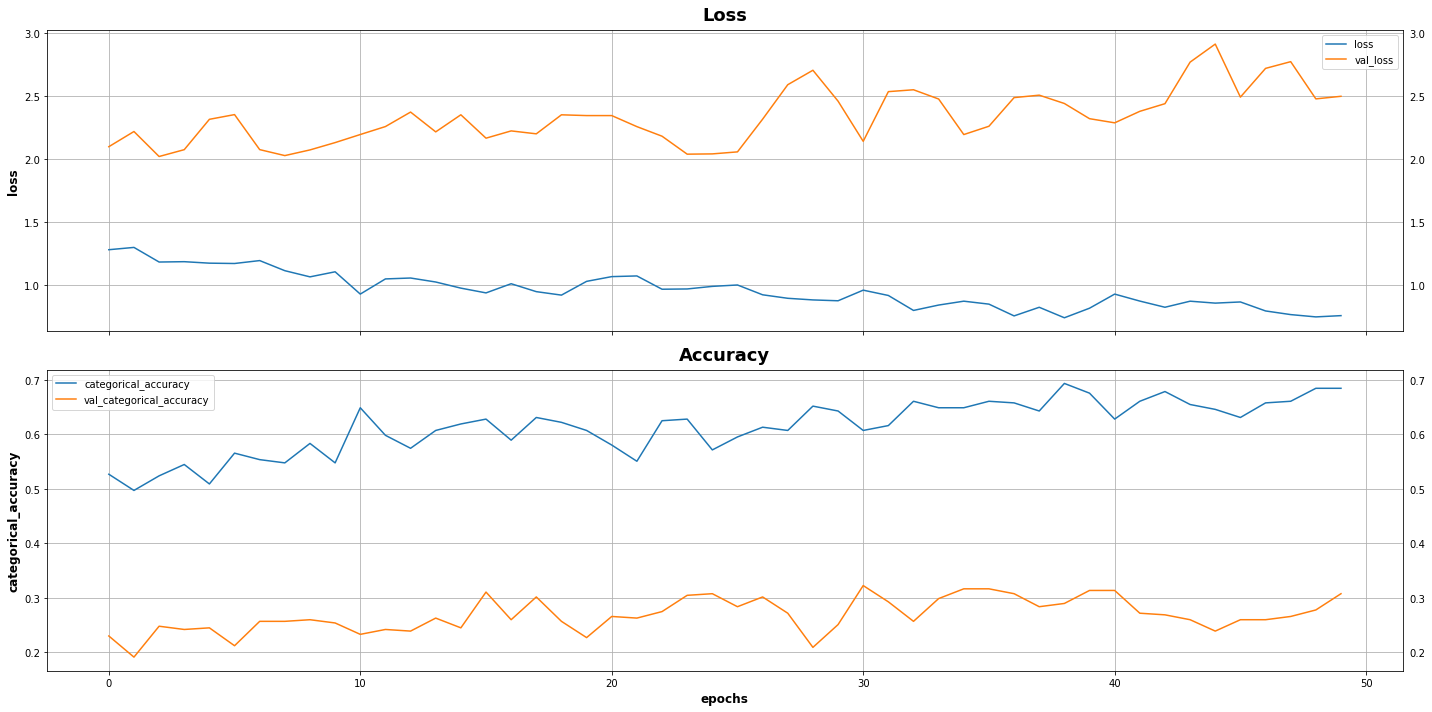

In [63]:
if config["custom"]["saved"]:

    history_df = pd.DataFrame(data=history.history)
    visualize_history(history_df)

***
# 5 Transfer learning CNN

## 5.1 VGG16

In [64]:
if config["transfer"]["vgg16"]:

    vgg16 = VGG16(
        include_top=False,
        input_shape=(224, 224, 3),
        weights="imagenet"
    )

    for layer in vgg16.layers:
        layer.trainable = False

In [65]:
if config["transfer"]["vgg16"]:

    model_vgg16 = keras.Sequential([
        # >>> base <<<
        vgg16,

        # >>> head <<<
        layers.GlobalAveragePooling2D(),

        layers.Dropout(rate=0.5),
        layers.Dense(units=fre_df.shape[0], activation="softmax")
    ])

    model_vgg16.summary()

In [66]:
if config["transfer"]["vgg16"]:

    model_vgg16.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    early_stopping = EarlyStopping(
        min_delta=0.001,
        patience=5,
        restore_best_weights=True
    )

    if not config["data_augmentation"]:
        print("Fit without aug")
        history_vgg16 = model_vgg16.fit(
            ds_train,
            validation_data=ds_valid,
            epochs=20,
            workers=8,
            # callbacks=[early_stopping],
            # verbose=0
        )
    else:
        print("Fit with aug")
        history_vgg16 = model_vgg16.fit_generator(
            train_aug,
            validation_data=val_aug,
            epochs=20,
            steps_per_epoch=100,
            workers=8
            # callbacks=[early_stopping]
            # verbose=0
        )

In [67]:
if config["transfer"]["vgg16"]:

    history_vgg16_df = pd.DataFrame(data=history_vgg16.history)
    visualize_history(history_vgg16_df)

***
### 5.1.1 Result without aug

<img src="plots/transfer_vgg16_without_aug.png" style="background-color:white">

***
### 5.1.2 Result with aug

<img src="plots/transfer_vgg16_with_aug.png" style="background-color:white">

***
## 5.2 Xception

In [68]:
if config["transfer"]["xception"]:

    xception = Xception(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(224, 224, 3)
    )

    for layer in xception.layers:
        layer.trainable = False

In [69]:
if config["transfer"]["xception"]:

    model_xception = keras.Sequential([
        # >>> base <<<
        xception,

        # >>> head <<<
        layers.Dense(units=128, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Dense(units=fre_df.shape[0], activation="softmax")
    ])

    model_xception.summary()

In [70]:
if config["transfer"]["xception"]:

    model_xception.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    filepath = './data/saves/xception.hdf5'
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        period=1
    )

    early_stopping = EarlyStopping(
        min_delta=0.001,
        patience=5,
        restore_best_weights=True
    )

    if not config["data_augmentation"]:
        print("Fit without aug")
        history_xception = model_xception.fit(
            ds_train,
            validation_data=ds_valid,
            epochs=50,
            workers=8,
            callbacks=[early_stopping, checkpoint],
            # verbose=0
        )
    else:
        print("Fit with aug")
        history_xception = model_xception.fit_generator(
            train_aug,
            validation_data=val_aug,
            epochs=50,
            steps_per_epoch=100,
            workers=8
            # callbacks=[early_stopping]
            # verbose=0
        )

In [71]:
if config["transfer"]["xception"]:

    history_xception_df = pd.DataFrame(data=history_xception.history)
    visualize_history(history_xception_df)

***
### 5.2.1 Result without aug

<img src="plots/transfer_xception_without_aug.png" style="background-color:white">

***
### 5.2.2 Result with aug

<img src="plots/transfer_xception_with_aug.png" style="background-color:white">